# Plot EM Slopes

Make some plots to show the EM slope for varying heating frequency

In [272]:
import os

import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d,splev,splrep
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import astropy.units as u
import astropy.constants as const
from sunpy.map import Map,GenericMap

from synthesizAR.util import EMCube

%matplotlib inline

In [96]:
frequencies = [250,
               750,
               #'750-ion',
               2500,
               5000]

## Plot EM Distributions 
Plot $\mathrm{EM}(T)$ over the whole AR 

### True

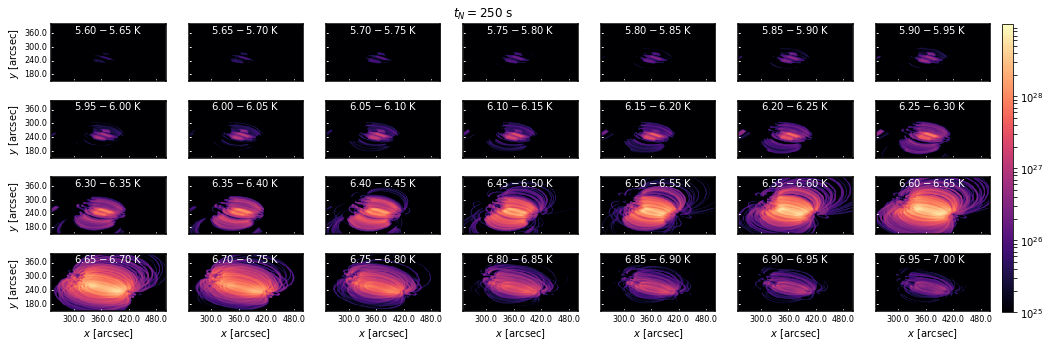

In [200]:
fig = plt.figure(figsize=(16,5))
fig.suptitle(r'$t_N=250$ s')
plt.subplots_adjust(right=0.94,top=0.94)
cax = fig.add_axes([0.95, 0.13, 0.01, 0.8])
tmp_em_cube = EMCube.restore('../data/em_cubes_true_tn250_t7500-12500.h5')
for i in range(tmp_em_cube.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = tmp_em_cube[i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,1)
    # set up axes properly and add plot
    ax = fig.add_subplot(4,7,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                  norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29),
                  cmap=plt.get_cmap('magma')
                 )
    # set title and labels
    xtext,ytext = tmp.data_to_pixel(300*u.arcsec,360*u.arcsec)
    ax.text(xtext.value,ytext.value,r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                                        t1=np.log10(tmp.meta['temp_b']),
                                                                        uni='K'),color='w')
    if i<21:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ [{}]'.format(u.Unit(tmp.meta['cunit1'])))
    if i%7==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks(size=2)
    ax.coords[1].set_ticks(size=2)
    ax.coords[0].ticklabels.set_fontsize(8)
    ax.coords[1].ticklabels.set_fontsize(8)
    
cbar = fig.colorbar(im,cax=cax)
fig.savefig('../loops-workshop-2017-talk/template/img/em_ar_true_tn{:04d}.png'.format(250),dpi=200,bbox_inches='tight')

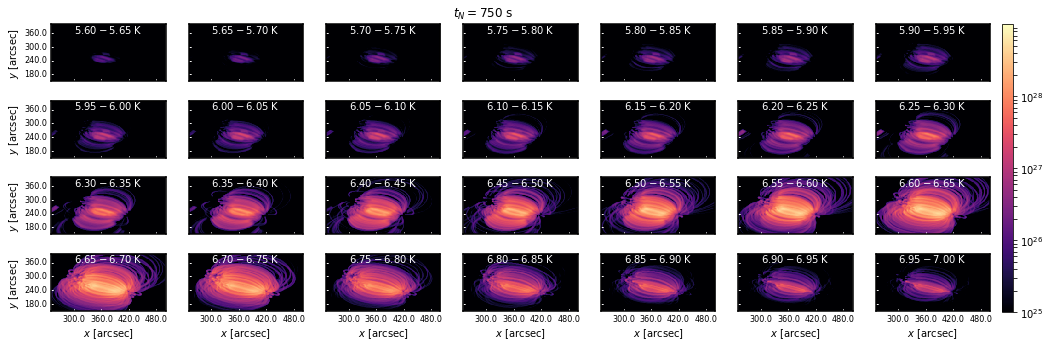

In [201]:
fig = plt.figure(figsize=(16,5))
fig.suptitle(r'$t_N=750$ s')
plt.subplots_adjust(right=0.94,top=0.94)
cax = fig.add_axes([0.95, 0.13, 0.01, 0.8])
tmp_em_cube = EMCube.restore('../data/em_cubes_true_tn750_t7500-12500.h5')
for i in range(tmp_em_cube.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = tmp_em_cube[i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,1)
    # set up axes properly and add plot
    ax = fig.add_subplot(4,7,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                  norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29),
                  cmap=plt.get_cmap('magma')
                 )
    # set title and labels
    xtext,ytext = tmp.data_to_pixel(300*u.arcsec,360*u.arcsec)
    ax.text(xtext.value,ytext.value,r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                                        t1=np.log10(tmp.meta['temp_b']),
                                                                        uni='K'),color='w')
    if i<21:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ [{}]'.format(u.Unit(tmp.meta['cunit1'])))
    if i%7==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks(size=2)
    ax.coords[1].set_ticks(size=2)
    ax.coords[0].ticklabels.set_fontsize(8)
    ax.coords[1].ticklabels.set_fontsize(8)
    
cbar = fig.colorbar(im,cax=cax)
fig.savefig('../loops-workshop-2017-talk/template/img/em_ar_true_tn{:04d}.png'.format(750),dpi=200,bbox_inches='tight')

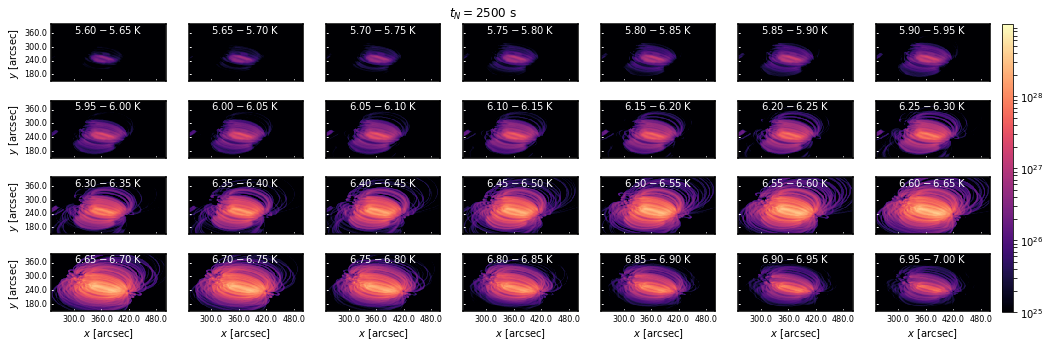

In [202]:
fig = plt.figure(figsize=(16,5))
fig.suptitle(r'$t_N=2500$ s')
plt.subplots_adjust(right=0.94,top=0.94)
cax = fig.add_axes([0.95, 0.13, 0.01, 0.8])
tmp_em_cube = EMCube.restore('../data/em_cubes_true_tn2500_t7500-12500.h5')
for i in range(tmp_em_cube.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = tmp_em_cube[i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,1)
    # set up axes properly and add plot
    ax = fig.add_subplot(4,7,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                  norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29),
                  cmap=plt.get_cmap('magma')
                 )
    # set title and labels
    xtext,ytext = tmp.data_to_pixel(300*u.arcsec,360*u.arcsec)
    ax.text(xtext.value,ytext.value,r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                                        t1=np.log10(tmp.meta['temp_b']),
                                                                        uni='K'),color='w')
    if i<21:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ [{}]'.format(u.Unit(tmp.meta['cunit1'])))
    if i%7==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks(size=2)
    ax.coords[1].set_ticks(size=2)
    ax.coords[0].ticklabels.set_fontsize(8)
    ax.coords[1].ticklabels.set_fontsize(8)
    
cbar = fig.colorbar(im,cax=cax)
fig.savefig('../loops-workshop-2017-talk/template/img/em_ar_true_tn{:04d}.png'.format(2500),dpi=200,bbox_inches='tight')

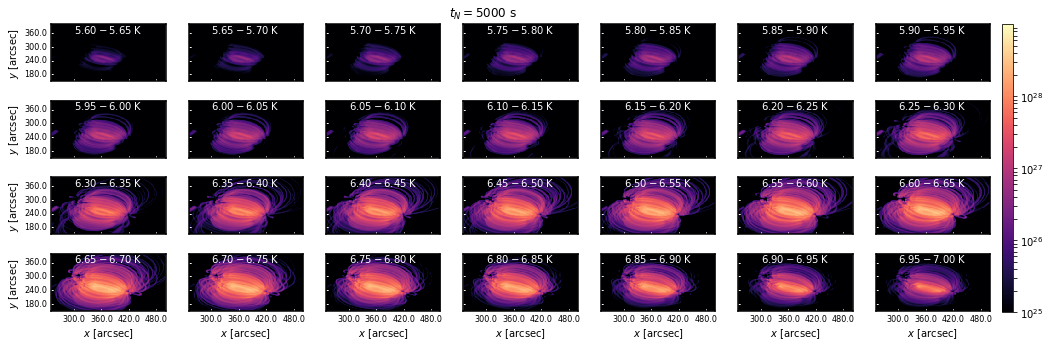

In [203]:
fig = plt.figure(figsize=(16,5))
fig.suptitle(r'$t_N=5000$ s')
plt.subplots_adjust(right=0.94,top=0.94)
cax = fig.add_axes([0.95, 0.13, 0.01, 0.8])
tmp_em_cube = EMCube.restore('../data/em_cubes_true_tn5000_t7500-12500.h5')
for i in range(tmp_em_cube.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = tmp_em_cube[i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,1)
    # set up axes properly and add plot
    ax = fig.add_subplot(4,7,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                  norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29),
                  cmap=plt.get_cmap('magma')
                 )
    # set title and labels
    xtext,ytext = tmp.data_to_pixel(300*u.arcsec,360*u.arcsec)
    ax.text(xtext.value,ytext.value,r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                                        t1=np.log10(tmp.meta['temp_b']),
                                                                        uni='K'),color='w')
    if i<21:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ [{}]'.format(u.Unit(tmp.meta['cunit1'])))
    if i%7==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks(size=2)
    ax.coords[1].set_ticks(size=2)
    ax.coords[0].ticklabels.set_fontsize(8)
    ax.coords[1].ticklabels.set_fontsize(8)
    
cbar = fig.colorbar(im,cax=cax)
fig.savefig('../loops-workshop-2017-talk/template/img/em_ar_true_tn{:04d}.png'.format(5000),dpi=200,bbox_inches='tight')

### Predicted

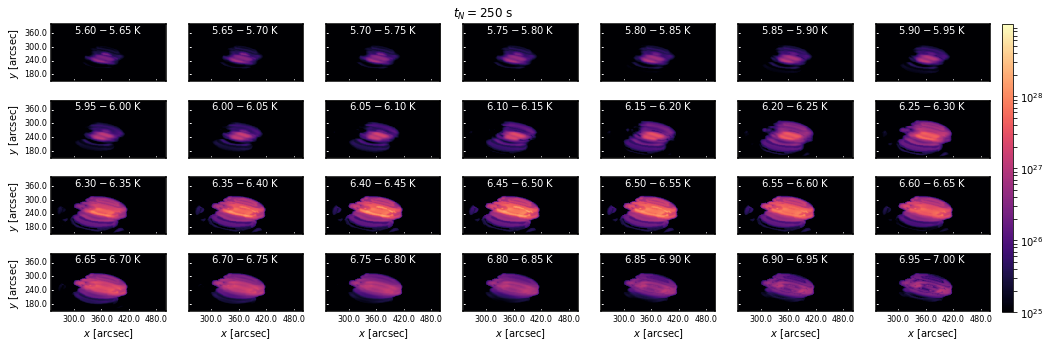

In [204]:
fig = plt.figure(figsize=(16,5))
fig.suptitle(r'$t_N=250$ s')
plt.subplots_adjust(right=0.94,top=0.94)
cax = fig.add_axes([0.95, 0.13, 0.01, 0.8])
tmp_em_cube = EMCube.restore('../data/em_cubes_demreg_tn250_t7500-12500.h5')
for i in range(tmp_em_cube.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = tmp_em_cube[i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,1)
    # set up axes properly and add plot
    ax = fig.add_subplot(4,7,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                  norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29),
                  cmap=plt.get_cmap('magma')
                 )
    # set title and labels
    xtext,ytext = tmp.data_to_pixel(300*u.arcsec,360*u.arcsec)
    ax.text(xtext.value,ytext.value,r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                                        t1=np.log10(tmp.meta['temp_b']),
                                                                        uni='K'),color='w')
    if i<21:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ [{}]'.format(u.Unit(tmp.meta['cunit1'])))
    if i%7==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks(size=2)
    ax.coords[1].set_ticks(size=2)
    ax.coords[0].ticklabels.set_fontsize(8)
    ax.coords[1].ticklabels.set_fontsize(8)
    
cbar = fig.colorbar(im,cax=cax)
fig.savefig('../loops-workshop-2017-talk/template/img/em_ar_predicted_tn{:04d}.png'.format(250),dpi=200,bbox_inches='tight')

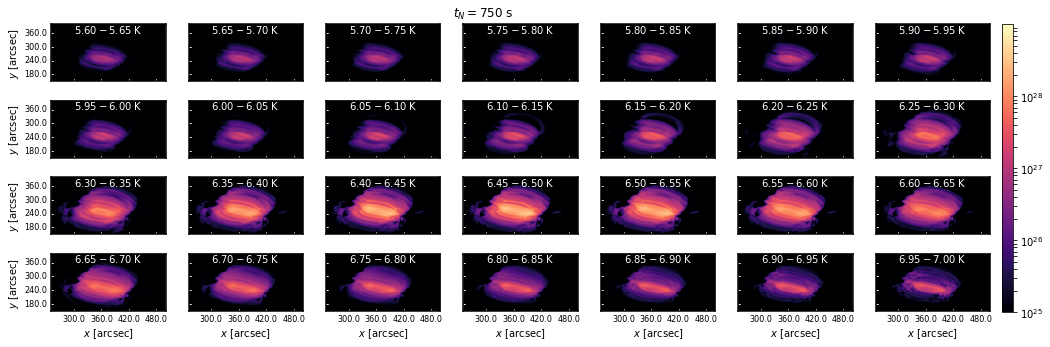

In [205]:
fig = plt.figure(figsize=(16,5))
fig.suptitle(r'$t_N=750$ s')
plt.subplots_adjust(right=0.94,top=0.94)
cax = fig.add_axes([0.95, 0.13, 0.01, 0.8])
tmp_em_cube = EMCube.restore('../data/em_cubes_demreg_tn750_t7500-12500.h5')
for i in range(tmp_em_cube.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = tmp_em_cube[i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,1)
    # set up axes properly and add plot
    ax = fig.add_subplot(4,7,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                  norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29),
                  cmap=plt.get_cmap('magma')
                 )
    # set title and labels
    xtext,ytext = tmp.data_to_pixel(300*u.arcsec,360*u.arcsec)
    ax.text(xtext.value,ytext.value,r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                                        t1=np.log10(tmp.meta['temp_b']),
                                                                        uni='K'),color='w')
    if i<21:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ [{}]'.format(u.Unit(tmp.meta['cunit1'])))
    if i%7==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks(size=2)
    ax.coords[1].set_ticks(size=2)
    ax.coords[0].ticklabels.set_fontsize(8)
    ax.coords[1].ticklabels.set_fontsize(8)
    
cbar = fig.colorbar(im,cax=cax)
fig.savefig('../loops-workshop-2017-talk/template/img/em_ar_predicted_tn{:04d}.png'.format(750),dpi=200,bbox_inches='tight')

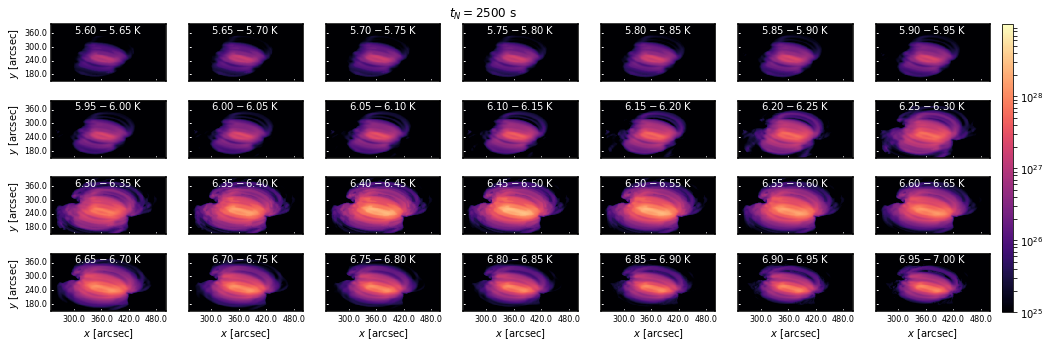

In [206]:
fig = plt.figure(figsize=(16,5))
fig.suptitle(r'$t_N=2500$ s')
plt.subplots_adjust(right=0.94,top=0.94)
cax = fig.add_axes([0.95, 0.13, 0.01, 0.8])
tmp_em_cube = EMCube.restore('../data/em_cubes_demreg_tn2500_t7500-12500.h5')
for i in range(tmp_em_cube.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = tmp_em_cube[i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,1)
    # set up axes properly and add plot
    ax = fig.add_subplot(4,7,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                  norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29),
                  cmap=plt.get_cmap('magma')
                 )
    # set title and labels
    xtext,ytext = tmp.data_to_pixel(300*u.arcsec,360*u.arcsec)
    ax.text(xtext.value,ytext.value,r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                                        t1=np.log10(tmp.meta['temp_b']),
                                                                        uni='K'),color='w')
    if i<21:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ [{}]'.format(u.Unit(tmp.meta['cunit1'])))
    if i%7==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks(size=2)
    ax.coords[1].set_ticks(size=2)
    ax.coords[0].ticklabels.set_fontsize(8)
    ax.coords[1].ticklabels.set_fontsize(8)
    
cbar = fig.colorbar(im,cax=cax)
fig.savefig('../loops-workshop-2017-talk/template/img/em_ar_predicted_tn{:04d}.png'.format(2500),dpi=200,bbox_inches='tight')

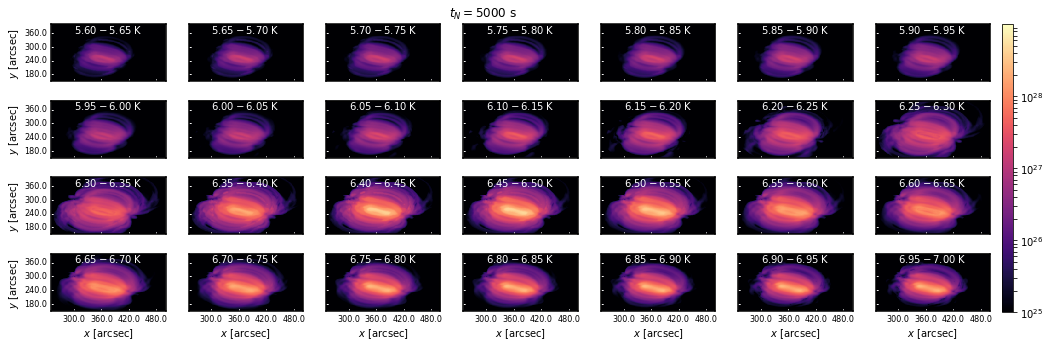

In [207]:
fig = plt.figure(figsize=(16,5))
fig.suptitle(r'$t_N=5000$ s')
plt.subplots_adjust(right=0.94,top=0.94)
cax = fig.add_axes([0.95, 0.13, 0.01, 0.8])
tmp_em_cube = EMCube.restore('../data/em_cubes_demreg_tn5000_t7500-12500.h5')
for i in range(tmp_em_cube.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = tmp_em_cube[i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,1)
    # set up axes properly and add plot
    ax = fig.add_subplot(4,7,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                  norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29),
                  cmap=plt.get_cmap('magma')
                 )
    # set title and labels
    xtext,ytext = tmp.data_to_pixel(300*u.arcsec,360*u.arcsec)
    ax.text(xtext.value,ytext.value,r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                                        t1=np.log10(tmp.meta['temp_b']),
                                                                        uni='K'),color='w')
    if i<21:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ [{}]'.format(u.Unit(tmp.meta['cunit1'])))
    if i%7==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks(size=2)
    ax.coords[1].set_ticks(size=2)
    ax.coords[0].ticklabels.set_fontsize(8)
    ax.coords[1].ticklabels.set_fontsize(8)
    
cbar = fig.colorbar(im,cax=cax)
fig.savefig('../loops-workshop-2017-talk/template/img/em_ar_predicted_tn{:04d}.png'.format(5000),dpi=200,bbox_inches='tight')

## Plot Slope Distributions

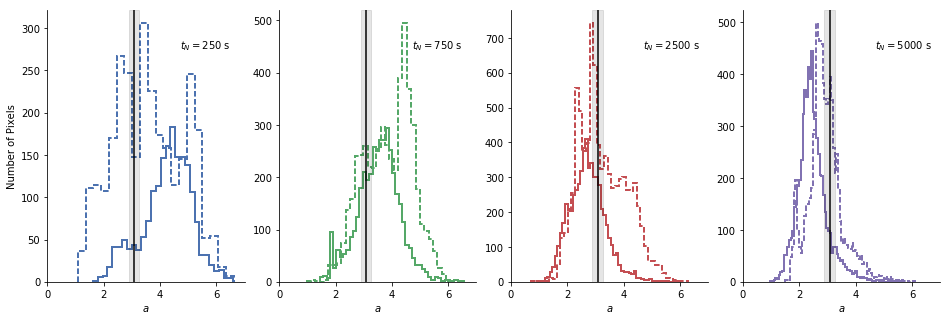

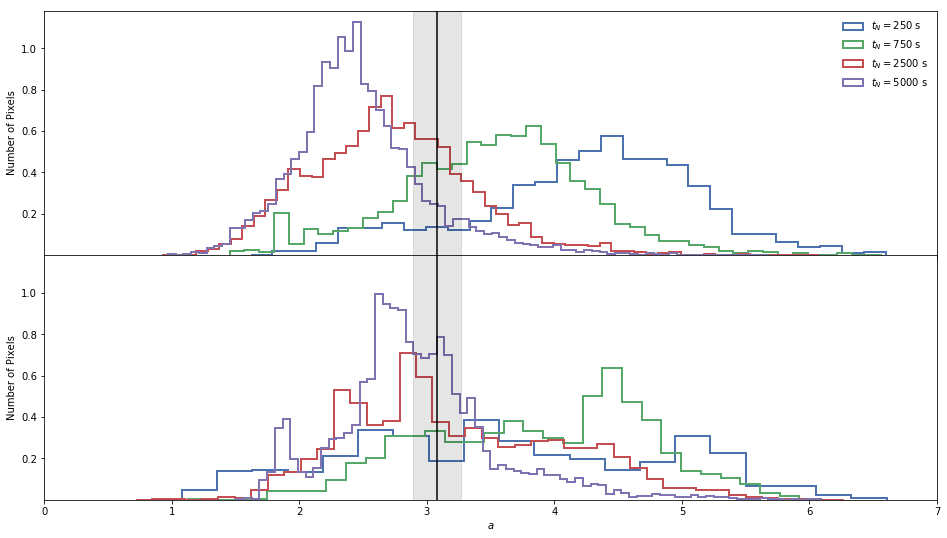

In [275]:
fig,axes = plt.subplots(1,4,figsize=(16,5),sharex=True,sharey=False)
plt.subplots_adjust(wspace=0.175)
fig2,axes2 = plt.subplots(2,1,figsize=(16,9),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0.)
colors = sns.color_palette('deep')
for ax,(i,freq) in zip(axes.flatten(),enumerate(frequencies)):
    #### Ground Truth ####
    tmp = (EMCube.restore('../data/em_cubes_true_tn{}_t7500-12500.h5'.format(freq))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,4e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .data.flatten()
          )
    tmp = tmp[tmp>0]
    _,bins = np.histogram(tmp,bins='fd')
    ax.hist(tmp,bins=bins,
            histtype='step',log=False,label='$t_N={}$ s, truth'.format(freq),normed=False,cumulative=False,
            lw=2,alpha=1.,color=colors[i])
    axes2[0].hist(tmp,bins=bins,
            histtype='step',log=False,label='$t_N={}$ s'.format(freq),normed=True,cumulative=False,
            lw=2,alpha=1.,color=colors[i])
    #### Regularized Inversion ####
    tmp = (EMCube.restore('../data/em_cubes_demreg_tn{}_t7500-12500.h5'.format(freq))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,3e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .data.flatten()
          )
    tmp = tmp[tmp>0]
    _,bins = np.histogram(tmp,bins='fd')
    hist,_,_ = ax.hist(tmp,bins=bins,
                       histtype='step',log=False,label='$t_N={}$ s, demreg'.format(freq),normed=False,
                       lw=2,ls='--',alpha=1.,cumulative=False,color=colors[i])
    axes2[1].hist(tmp,bins=bins,
            histtype='step',log=False,normed=True,
            lw=2,ls='-',alpha=1.,cumulative=False,color=colors[i])
    #### Warren et al result ####
    # from paper
    warren_a_ar9_nominal_hk12 = 3.08
    warren_a_ar9_minus_hk12 = warren_a_ar9_nominal_hk12 - 0.19
    warren_a_ar9_plus_hk12 = warren_a_ar9_nominal_hk12 + 0.19
    #ax.axvspan(warren_a_ar9_nominal - warren_a_ar9_uncertainty,
    #           warren_a_ar9_nominal + warren_a_ar9_uncertainty,
    #          color='k',alpha=0.1)
    #ax.axvline(x=warren_a_ar9_nominal,color='k')
    # from HK12 applied to reported intensities
    ax.axvspan(warren_a_ar9_minus_hk12,
               warren_a_ar9_plus_hk12,
              color='k',alpha=0.1)
    ax.axvline(x=warren_a_ar9_nominal_hk12,color='k')
    ax.set_xlim([0,7])
    #ax.legend(loc=2)
    ax.set_xlabel(r'$a$')
    ax.text(4.7,0.9*np.max(hist),r'$t_N={}$ s'.format(freq),
            fontsize=matplotlib.rcParams['axes.labelsize'])

axes2[0].axvspan(warren_a_ar9_minus_hk12,
               warren_a_ar9_plus_hk12,
              color='k',alpha=0.1)
axes2[0].axvline(x=warren_a_ar9_nominal_hk12,color='k')
axes2[1].axvspan(warren_a_ar9_minus_hk12,
               warren_a_ar9_plus_hk12,
              color='k',alpha=0.1)
axes2[1].axvline(x=warren_a_ar9_nominal_hk12,color='k')
axes[0].set_ylabel(r'Number of Pixels')
axes2[0].set_xlim([0,7])
axes2[0].legend(loc='best',frameon=False)
axes2[1].set_xlabel(r'$a$')
axes2[0].set_ylabel(r'Number of Pixels')
axes2[1].set_ylabel(r'Number of Pixels')
axes2[0].yaxis.set_major_locator(MaxNLocator(nbins=len(axes2[0].get_yticklabels()), prune='lower'))
sns.despine(fig=fig)
fig.savefig('../loops-workshop-2017-talk/template/img/em_slope_4panel.png',dpi=200,bbox_inches='tight')
fig2.savefig('../loops-workshop-2017-talk/template/img/em_slope_2panel.png',dpi=200,bbox_inches='tight')

## Emission Measure Slope Maps

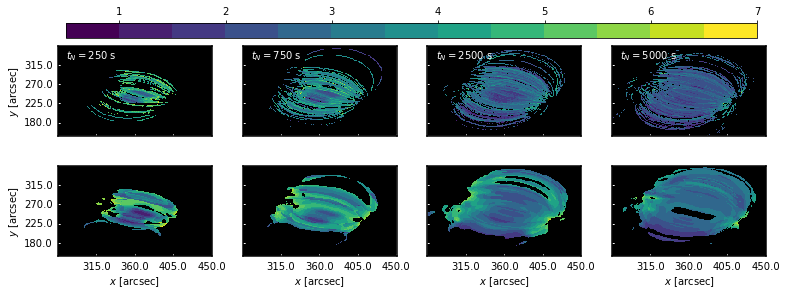

In [271]:
fig = plt.figure(figsize=(16,4))
plt.subplots_adjust(top=0.89)
cax = fig.add_axes([0.132, 0.9,0.6, 0.05])
custom_cmap = plt.get_cmap('viridis')#matplotlib.colors.ListedColormap(sns.color_palette('deep'))#plt.get_cmap('Set1')
custom_cmap.set_under(color='k')
norm = matplotlib.colors.BoundaryNorm(np.arange(0.5,7.5,0.5),custom_cmap.N)
for i,freq in enumerate(frequencies):
    #### Ground Truth ####
    tmp = (EMCube.restore('../data/em_cubes_true_tn{}_t7500-12500.h5'.format(freq))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,4e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .submap(u.Quantity((270,450),u.arcsec),u.Quantity((150,360),u.arcsec))
          )
    ax = fig.add_subplot(2,5,i+1,projection=tmp)
    im = (tmp.plot(#vmin=0.5,
                   #vmax=7,
                   cmap=custom_cmap,
                   axes=ax,
                   title=False,
                   annotate=False,
                   norm=norm))
    if i==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks(size=2)
    ax.coords[1].set_ticks(size=2)
    xtext,ytext = tmp.data_to_pixel(280*u.arcsec,330*u.arcsec)
    ax.text(xtext.value,ytext.value,r'$t_N={}$ s'.format(freq),color='w')
    #### Regularized Inversion ####
    tmp = (EMCube.restore('../data/em_cubes_demreg_tn{}_t7500-12500.h5'.format(freq))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,3e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .submap(u.Quantity((270,450),u.arcsec),u.Quantity((150,360),u.arcsec))
          )
    ax = fig.add_subplot(2,5,i+6,projection=tmp)
    im = (tmp.plot(#vmin=0.5,
                   #vmax=7,
                   cmap=custom_cmap,
                   axes=ax,
                   title=False,
                   annotate=False,
                   norm=norm))
    ax.set_xlabel(r'$x$ [{}]'.format(u.Unit(tmp.meta['cunit1'])))
    if i==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks(size=2)
    ax.coords[1].set_ticks(size=2)
        
cbar = fig.colorbar(im,cax=cax,orientation='horizontal')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_ticks(np.linspace(1,7,7))
fig.savefig('../loops-workshop-2017-talk/template/img/em_slope_maps.png',dpi=200,bbox_inches='tight')